In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

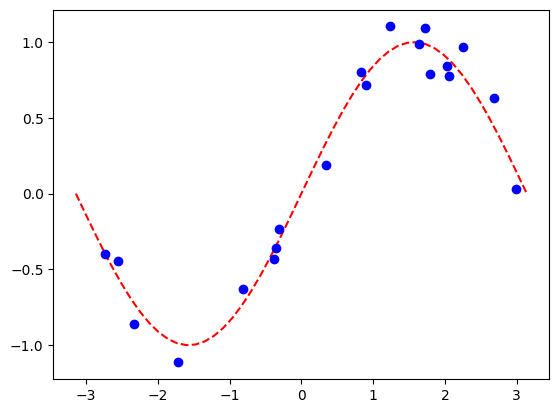

In [3]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

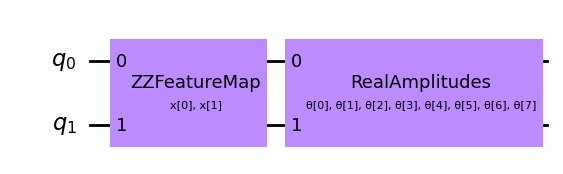

In [5]:
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum")
for backend in service.backends():
    status = backend.status()
    print(f"Backend: {backend.name}, Qubits: {backend.num_qubits}, Status: {'Operational' if status.operational else 'Not Operational'}, Pending Jobs: {status.pending_jobs}")


Backend: ibm_brisbane, Qubits: 127, Status: Operational, Pending Jobs: 1
Backend: ibm_brussels, Qubits: 127, Status: Operational, Pending Jobs: 0
Backend: ibm_fez, Qubits: 156, Status: Operational, Pending Jobs: 794
Backend: ibm_kyiv, Qubits: 127, Status: Operational, Pending Jobs: 2
Backend: ibm_marrakesh, Qubits: 156, Status: Operational, Pending Jobs: 968
Backend: ibm_sherbrooke, Qubits: 127, Status: Operational, Pending Jobs: 0
Backend: ibm_strasbourg, Qubits: 127, Status: Operational, Pending Jobs: 0
Backend: ibm_torino, Qubits: 133, Status: Operational, Pending Jobs: 17


In [33]:
from qiskit_ibm_runtime import QiskitRuntimeService , Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Pauli

service = QiskitRuntimeService(channel="ibm_quantum")

backend = service.backend("ibm_brisbane")

estimator = Estimator(backend=backend)

qc = RealAmplitudes(num_qubits=4, reps=2)
observable = Pauli("ZZZZ")
params = np.random.rand(qc.num_parameters)

# job = estimator.run(
#     circuits=[qc],
#     observables=[observable],
#     backend=backend,
#     parameter_values=[params],
#     shots=1 
# )

# result = job.result()
# print("Estimator Result:", result.values)


TypeError: EstimatorV2.__init__() got an unexpected keyword argument 'backend'

In [7]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

regression_estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [9]:
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

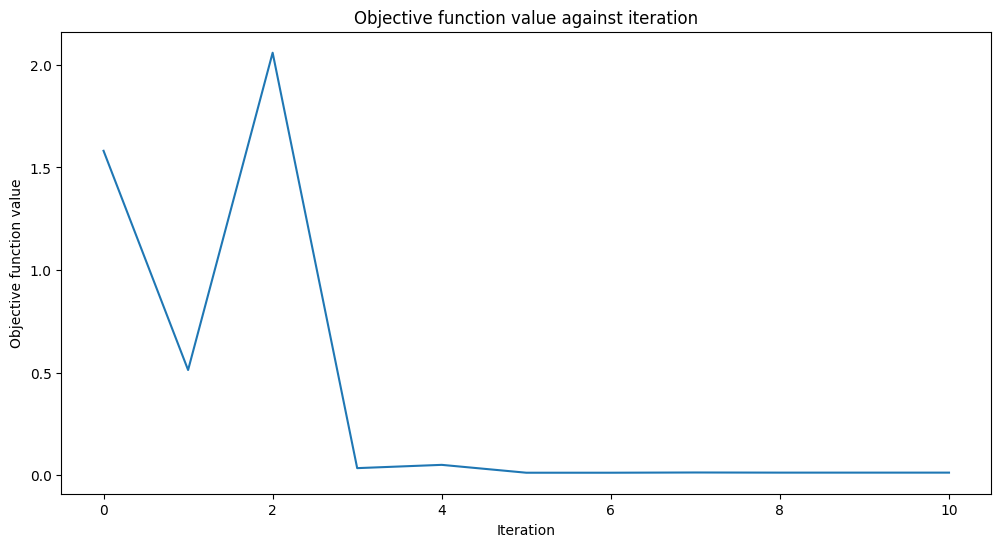

0.9747761914191508

In [10]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

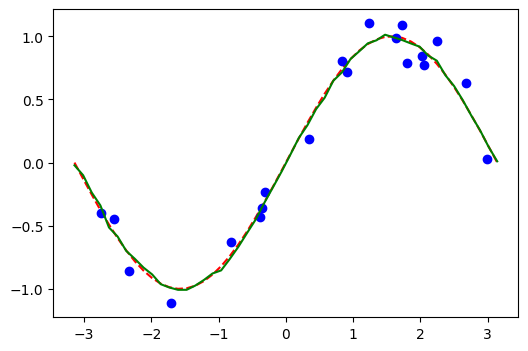

In [11]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()